<a href="https://colab.research.google.com/github/Carabinero/politeness-review-classification/blob/main/politeness_convencional_v1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Definição do Problema

Trata-se do problema de classificar o tom de polidez de revisões de artigos.
O dataset possui 2500 instancias classificadas em 5 niveis de polidez mutuamente excludente (cada amostra pertence a apenas uma classe).

### 1.1 Carregamento das bibliotecas

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from string import punctuation
import re
from transformers import pipeline, AutoTokenizer, AutoModel
from gensim import utils
import gensim.models
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
)
from wordcloud import WordCloud
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
# from sklearn.ensemble import MetaEstimator
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Download 'wordnet' for lemmatization
nltk.download('stopwords') # Download stopwords
import shap
import numpy as np



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Preparação dos Dados
Análise e pré-processamento:

Verifique se os dados estão balanceados entre as classes. Se houver desbalanceamento, considere técnicas como oversampling (SMOTE) ou undersampling.
- Normalização ou padronização dos atributos numéricos.
- Codificação de atributos categóricos (e.g., one-hot encoding, label encoding).

Divisão dos Dados:

- Divida o conjunto de dados em treino, validação e teste (e.g., 70% treino, 15% validação, 15% teste).
Codificação das Classes:

- Use label encoding para multi-classe.
- Para multi-label, utilize multi-hot encoding.


### 2.1 Carregamento dos dados e limpeza inicial

In [11]:
df = pd.read_csv('sample_data/PolitenessDataset-FULL.csv')
print(df.shape)
df.drop(['Review ID', 'Venue', 'Review URL'], axis=1, inplace=True)
df.dropna(inplace=True)
df

(2500, 5)


,review,Tone
0,"It is early in the year, but difficult to imag...",2
1,You do not use the empirical data for the anal...,2
2,I understand that Wikipedia is not the best so...,3
3,Reviewer #1: 'The project can hardly be descri...,3
4,The figures are dishonest and not all that use...,2
...,...,...
2495,The scientific contribution of this paper - if...,2
2496,Reviewer 2: The proposal is also poorly writte...,2
2497,The paper could be considered for acceptance g...,3
2498,I don't see how your approach has potential to...,2


In [12]:
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

def preplem(instance_review: str):

    # Get English stop words from NLTK
    english_stops = set(stopwords.words('english'))

    # Tokenize the article: tokens
    tokens = word_tokenize(instance_review)

    # Convert the tokens into lowercase: lower_tokens
    lower_tokens = [t.lower() for t in tokens]

    # Retain alphabetic words: alpha_only
    alpha_only = [t for t in lower_tokens if t.isalpha()]

    # Remove all stop words: no_stops
    no_stops = [t for t in alpha_only if t not in english_stops]

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in alpha_only]
    return ' '.join(lemmatized)


df['review_pro'] = df['review'].apply(preprocess)
df['review_pro2'] = df['review_pro'].apply(preplem)

# df = df.drop(["review"], axis=1)
# df = df.rename(columns={"review_pro": "review"})
df = df.rename(columns={"Tone": "tone"})
# print(df.columns)
df

,review,tone,review_pro,review_pro2
0,"It is early in the year, but difficult to imag...",2,it is early in the year but difficult to imagi...,it is early in the year but difficult to imagi...
1,You do not use the empirical data for the anal...,2,you do not use the empirical data for the anal...,you do not use the empirical data for the anal...
2,I understand that Wikipedia is not the best so...,3,i understand that wikipedia is not the best so...,i understand that wikipedia is not the best so...
3,Reviewer #1: 'The project can hardly be descri...,3,reviewer the project can hardly be described...,reviewer the project can hardly be described a...
4,The figures are dishonest and not all that use...,2,the figures are dishonest and not all that useful,the figure are dishonest and not all that useful
...,...,...,...,...
2495,The scientific contribution of this paper - if...,2,the scientific contribution of this paper if t...,the scientific contribution of this paper if t...
2496,Reviewer 2: The proposal is also poorly writte...,2,reviewer the proposal is also poorly written...,reviewer the proposal is also poorly written a...
2497,The paper could be considered for acceptance g...,3,the paper could be considered for acceptance g...,the paper could be considered for acceptance g...
2498,I don't see how your approach has potential to...,2,i don t see how your approach has potential to...,i don t see how your approach ha potential to ...


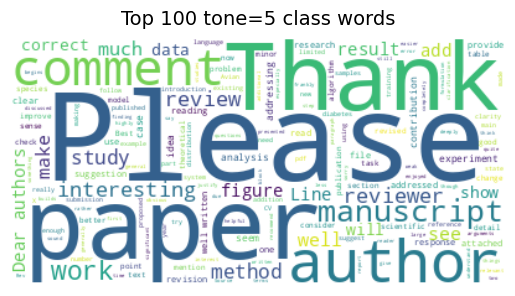

In [13]:
positive_df = df[df["tone"] == 5]["review"][:100]
positive_df = reduce(lambda a, b: a + b, positive_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(positive_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 tone=5 class words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

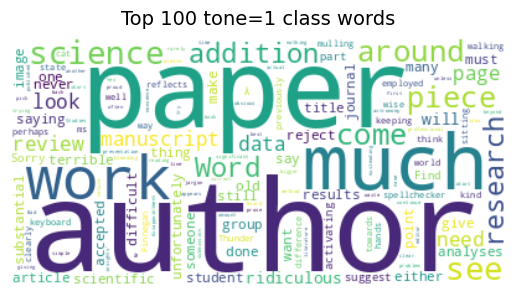

In [14]:
negative_df = df[df["tone"] == 1]["review"][:100]
negative_df = reduce(lambda a, b: a + b, negative_df)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate(negative_df)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 tone=1 class words", y=1.02, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

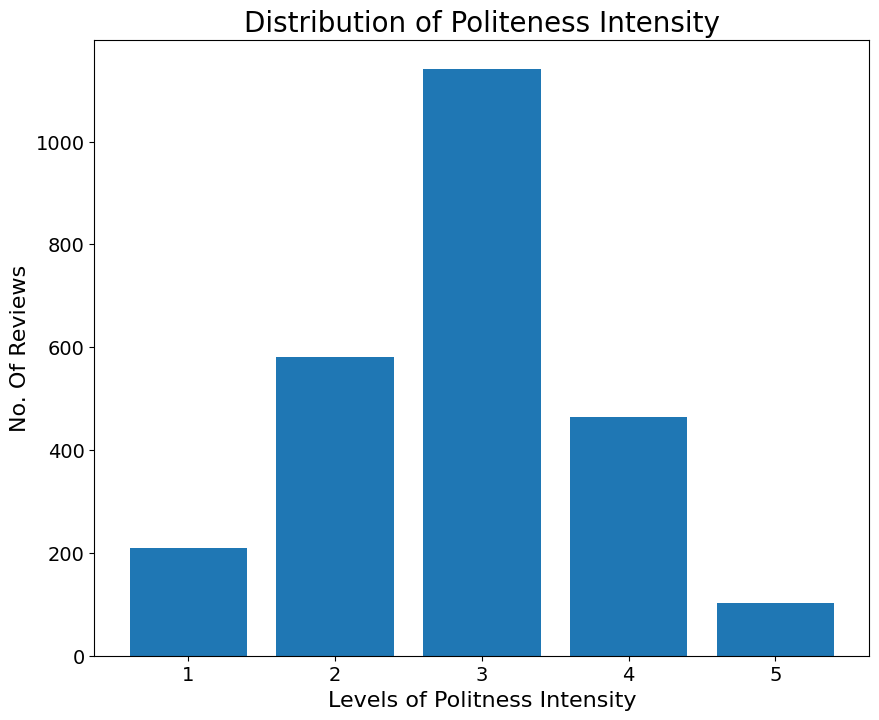

In [15]:
def plotClassDistri(df, cols):

    labels_val = dict(df[cols].value_counts())
    sorted_vals = [labels_val[key] for key in sorted(labels_val.keys())]

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.bar( sorted(labels_val.keys()), sorted_vals)
    plt.title("Distribution of Politeness Intensity", fontsize=20)
    plt.xlabel("Levels of Politness Intensity",fontsize=16)
    plt.ylabel("No. Of Reviews", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()


plotClassDistri(df,'tone')

In [16]:
df.tone.value_counts()

,count
tone,
3,1141
2,581
4,465
1,210
5,102


### 2.2 Tratando o desbalanceamento entre classes

### 2.3 One Hot Encoder

In [17]:
# Specify the columns you wish to one-hot encode
categorical_columns = [
    "tone"
]
# upsampled_df.columns

# Perform the one-hot encoding
# ohe_df = pd.get_dummies(upsampled_df, columns=categorical_columns)
ohe_df = pd.get_dummies(df, columns=categorical_columns)

# View the resulting DataFrame
ohe_df

,review,review_pro,review_pro2,tone_1,tone_2,tone_3,tone_4,tone_5
0,"It is early in the year, but difficult to imag...",it is early in the year but difficult to imagi...,it is early in the year but difficult to imagi...,False,True,False,False,False
1,You do not use the empirical data for the anal...,you do not use the empirical data for the anal...,you do not use the empirical data for the anal...,False,True,False,False,False
2,I understand that Wikipedia is not the best so...,i understand that wikipedia is not the best so...,i understand that wikipedia is not the best so...,False,False,True,False,False
3,Reviewer #1: 'The project can hardly be descri...,reviewer the project can hardly be described...,reviewer the project can hardly be described a...,False,False,True,False,False
4,The figures are dishonest and not all that use...,the figures are dishonest and not all that useful,the figure are dishonest and not all that useful,False,True,False,False,False
...,...,...,...,...,...,...,...,...
2495,The scientific contribution of this paper - if...,the scientific contribution of this paper if t...,the scientific contribution of this paper if t...,False,True,False,False,False
2496,Reviewer 2: The proposal is also poorly writte...,reviewer the proposal is also poorly written...,reviewer the proposal is also poorly written a...,False,True,False,False,False
2497,The paper could be considered for acceptance g...,the paper could be considered for acceptance g...,the paper could be considered for acceptance g...,False,False,True,False,False
2498,I don't see how your approach has potential to...,i don t see how your approach has potential to...,i don t see how your approach ha potential to ...,False,True,False,False,False


## 2.5 Separando dados de treinamento e teste

In [10]:
# dropped = upsampled_df.drop(["review"], axis=1)
# transformed = pd.concat([dropped, df_transformed], axis=1)
# transformed


In [11]:
# tone_cols = [col for col in transformed.columns if col.startswith("tone_")]
# X = transformed.drop(columns=tone_cols, axis=1) # Drop columns starting with "tone_"
# X

In [18]:
y_5 = ohe_df["tone_5"].astype(int)
y_4 = ohe_df["tone_4"].astype(int)
y_3 = ohe_df["tone_3"].astype(int)
y_2 = ohe_df["tone_2"].astype(int)
y_1 = ohe_df["tone_1"].astype(int)

print(y_5.value_counts())
print(y_4.value_counts())
print(y_3.value_counts())
print(y_2.value_counts())
print(y_1.value_counts())

tone_5
0    2397
1     102
Name: count, dtype: int64
tone_4
0    2034
1     465
Name: count, dtype: int64
tone_3
0    1358
1    1141
Name: count, dtype: int64
tone_2
0    1918
1     581
Name: count, dtype: int64
tone_1
0    2289
1     210
Name: count, dtype: int64


In [19]:
# Train/test split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
    ohe_df['review_pro2'],
    y_5,
    stratify=y_5,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=42,  # Random seed for reproducibility
)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    ohe_df['review_pro2'],
    y_4,
    stratify=y_4,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=42,  # Random seed for reproducibility
)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    ohe_df['review_pro2'],
    y_3,
    stratify=y_3,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=42,  # Random seed for reproducibility
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    ohe_df['review_pro2'],
    y_2,
    stratify=y_2,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=42,  # Random seed for reproducibility
)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    ohe_df['review_pro2'],
    y_1,
    stratify=y_1,  # Stratify based on the target
    test_size=0.2,  # Set size of test_set
    random_state=42,  # Random seed for reproducibility
)




### 2.3 Criando os vetores Tfidf para cada conjunto de treinamento, garantindo que não haja vazamento de dados de teste

- Permite determinar as palavras mais importantes em cada documento

- Term frequency - inverse document frequency : Tfidf = Tf * idf (peso do token no documento)

 - Term frequency : quantas vezes o termo (token) aparece no documento / quantos tokens tem o documento

 - inverse document frequency : log (qtd de documentos na base / qtd de documentos em que o token aparece )

- Garante que as palavras mais comuns nao apareçam com palavras-chaves

- Mantém palavras frequentes específicas do documento com peso maior

In [20]:
# Build the vectorizer
vect_1 = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    # max_features=500,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

X_train_tfidf_1 = vect_1.fit_transform(X_train_1)
X_test_tfidf_1 = vect_1.transform(X_test_1)

# ---

vect_2 = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    # max_features=500,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

X_train_tfidf_2 = vect_2.fit_transform(X_train_2)
X_test_tfidf_2 = vect_2.transform(X_test_2)

# ---

vect_3 = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    # max_features=500,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

X_train_tfidf_3 = vect_3.fit_transform(X_train_3)
X_test_tfidf_3 = vect_3.transform(X_test_3)

# ---

vect_4 = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    # max_features=500,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

X_train_tfidf_4 = vect_4.fit_transform(X_train_4)
X_test_tfidf_4 = vect_4.transform(X_test_4)

# ---

vect_5 = TfidfVectorizer(
    stop_words='english',  # Default list of English stop words
    ngram_range=(1, 2),  # Consider Uni- and Bi-grams
    # max_features=500,  # Max number of features
    token_pattern=r"\b[^\d\W][^\d\W]+\b",  # Capture only words using this pattern
)

X_train_tfidf_5 = vect_5.fit_transform(X_train_5)
X_test_tfidf_5 = vect_5.transform(X_test_5)


## 3. Escolha do Modelo
Selecione modelos que suportam classificação multi-classe diretamente, ou implemente estratégias para transformar o problema.

Modelos que Suportam Multi-Classe Diretamente:
- Árvores de Decisão (e.g., Random Forest, Gradient Boosting, XGBoost).
- Regressão Logística Multiclasse.
- Redes Neurais.
- K-Nearest Neighbors (kNN).
- Máquinas de Vetores de Suporte (SVM) com kernel apropriado.

Estratégias para Modelos que Não Suportam Multi-Classe Nativamente:
- One-vs-Rest (OvR):
 - Treina um modelo binário para cada classe, tratando-a como "positiva" e as outras como "negativas".
- One-vs-One (OvO):
 - Treina um modelo binário para cada par de classes e utiliza votação para decidir o rótulo final.

Essas estratégias são aplicáveis, por exemplo, para SVMs e modelos lineares.



### 3.1 Avaliação dos modelos

In [21]:
from collections import defaultdict
import time

def train_and_evaluate_models(X_train_data, X_test_data, y_train_data, y_test_data, tone_levels):
    """
    Trains specified models for each tone level and stores them in a dictionary.

    Args:
        model_classes: A list of model classes (e.g., [LogisticRegression, KNeighborsClassifier, GaussianNB]).
        X_train_data: A dictionary containing training data features for each tone level.
        X_test_data: A dictionary containing testing data features for each tone level.
        y_train_data: A dictionary containing training data labels for each tone level.
        y_test_data: A dictionary containing testing data labels for each tone level.
        tone_levels: A list of tone levels (e.g., [5, 4, 3, 2, 1]).

    Returns:
        A dictionary where keys are tone levels and values are dictionaries containing trained models.
    """
    trained_models = defaultdict(dict)  # Use defaultdict to store models for each tone level
    accuracy_results = defaultdict(dict)  # Store accuracy results
    f1_results = defaultdict(dict)  # Store F1 scores
    training_times = defaultdict(dict) # Store training times

    for tone_level in tone_levels:
        for model_info in [
            (LogisticRegression, {'random_state': 42}),
            (KNeighborsClassifier, {'n_neighbors': 5}),
            (BernoulliNB, {}),  # No parameters for BernoulliNB
            (MultinomialNB, {}), #No parameters for MultinomialNB
            (MLPClassifier, {'hidden_layer_sizes': 50, 'solver': 'lbfgs', 'max_iter': 10000, 'random_state': 42}),
            (RandomForestClassifier, {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'random_state': 42}),
            (XGBClassifier, {}) #No parameters for XGBClassifier
        ]:
            model_class, model_params = model_info

            # Record start time
            start_time = time.time()

            # Create and train the model
            model = model_class(**model_params)

            model.fit(X_train_data[tone_level], y_train_data[tone_level])

            model_name = model_class.__name__

            # Record end time and calculate training time
            end_time = time.time()
            training_time = end_time - start_time
            training_times[model_name][tone_level] = training_time

            # Predict the labels
            y_predicted = model.predict(X_test_data[tone_level])

            # Calculate and store accuracy
            accuracy = accuracy_score(y_test_data[tone_level], y_predicted)
            accuracy_results[model_name][tone_level] = accuracy

            # Calculate and store F1 score (macro average)
            f1 = f1_score(y_test_data[tone_level], y_predicted, average='macro')
            f1_results[model_name][tone_level] = f1

            trained_models[f"{model_name}_{tone_level}"] = model


            # print(f"{model_name}_{tone_level}")
            # print(model.predict_proba(X.iloc[[0],:]))
            # print(model.predict(X.iloc[[0],:]))
            # Store the trained model
            trained_models[f"{model_name}_{tone_level}"] = model

    # Create the accuracy table
    accuracy_df = pd.DataFrame(accuracy_results).T  # Transpose for desired format
    accuracy_df.columns.name = "Tone Level" #set the name of the columns
    accuracy_df.index.name = "Model" #set the name of the lines

    # Create the F1 score table
    f1_df = pd.DataFrame(f1_results).T
    f1_df.columns.name = "Tone Level"
    f1_df.index.name = "Model"
    f1_df['Average'] = f1_df.mean(axis=1)

    # Create the training time table
    training_times_df = pd.DataFrame(training_times).T
    training_times_df.columns.name = "Tone Level"
    training_times_df.index.name = "Model"
    training_times_df['Average'] = training_times_df.mean(axis=1)

    # Calculate average accuracy for each model
    accuracy_df['Average Accuracy'] = accuracy_df.mean(axis=1)
    # accuracy_df['Average F1'] = f1_df.mean(axis=1)
    # accuracy_df['Average Time'] = training_times_df.mean(axis=1)
    # accuracy_df['Total Time'] = training_times_df.sum(axis=1)


    return trained_models, accuracy_df, f1_df, training_times_df

# Data dictionaries for training and testing data (assuming you have them defined)
X_train_data = {5: X_train_tfidf_5, 4: X_train_tfidf_4, 3: X_train_tfidf_3, 2: X_train_tfidf_2, 1: X_train_tfidf_1}
X_test_data = {5: X_test_tfidf_5, 4: X_test_tfidf_4, 3: X_test_tfidf_3, 2: X_test_tfidf_2, 1: X_test_tfidf_1}
y_train_data = {5: y_train_5, 4: y_train_4, 3: y_train_3, 2: y_train_2, 1: y_train_1}
y_test_data = {5: y_test_5, 4: y_test_4, 3: y_test_3, 2: y_test_2, 1: y_test_1}

max_iterations = 10000

# List of model classes
# model_classes = [
#     LogisticRegression(random_state=42),
#     KNeighborsClassifier(n_neighbors=5),
#     BernoulliNB(),
#     MultinomialNB(),
#     MLPClassifier(hidden_layer_sizes=50, solver='lbfgs', max_iter=max_iterations, random_state=42),
#     RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=42),
#     XGBClassifier()
# ]
# svm, random forest,

# List of tone levels
tone_levels = [5, 4, 3, 2, 1]

# Train and evaluate models
trained_models_, accuracy_df, f1_df, training_times_df = train_and_evaluate_models(X_train_data, X_test_data, y_train_data, y_test_data, tone_levels)

# Accessing trained models
# Example: Accessing the LogisticRegression model for tone level 5
# log_reg_model_tone_5 = trained_models[5]['LogisticRegression']

In [22]:
# accuracy_df['Average Accuracy'] = accuracy_df.mean(axis=1)
# print("\nAverage Accuracy per Model:")
# accuracy_table[['Average Accuracy']] #print a table with the average accuracy
accuracy_df


Tone Level,5,4,3,2,1,Average Accuracy
Model,,,,,,
LogisticRegression,0.960,0.814,0.636,0.770,0.916,0.8192
KNeighborsClassifier,0.960,0.814,0.540,0.770,0.916,0.8000
BernoulliNB,0.960,0.814,0.626,0.768,0.916,0.8168
MultinomialNB,0.960,0.814,0.652,0.768,0.916,0.8220
MLPClassifier,0.968,0.782,0.608,0.746,0.910,0.8028
RandomForestClassifier,0.958,0.818,0.644,0.750,0.916,0.8172
XGBClassifier,0.964,0.814,0.620,0.738,0.906,0.8084


In [198]:
f1_df


Tone Level,5,4,3,2,1,Average
Model,,,,,,
LogisticRegression,0.489796,0.448732,0.623245,0.443428,0.478079,0.496656
KNeighborsClassifier,0.489796,0.448732,0.362188,0.459378,0.478079,0.447635
BernoulliNB,0.489796,0.448732,0.591658,0.442715,0.478079,0.490196
MultinomialNB,0.489796,0.448732,0.634300,0.442715,0.478079,0.498724
MLPClassifier,0.684094,0.611931,0.606767,0.626275,0.629782,0.631770
RandomForestClassifier,0.489275,0.480540,0.634647,0.512477,0.500761,0.523540
XGBClassifier,0.644606,0.562801,0.616465,0.524587,0.531789,0.576050


In [26]:
training_times_df["Total"] = 0
training_times_df["Total"] = training_times_df.sum(axis=1)
training_times_df

Tone Level,5,4,3,2,1,Average,Total
Model,,,,,,,
LogisticRegression,0.230405,0.219818,0.639533,0.785609,0.219604,0.418994,2.513962
KNeighborsClassifier,0.001549,0.001324,0.001432,0.008426,0.001533,0.002853,0.017117
BernoulliNB,0.003566,0.009026,0.004493,0.006536,0.012492,0.007222,0.043334
MultinomialNB,0.002464,0.003762,0.004001,0.006419,0.008466,0.005022,0.030135
MLPClassifier,6.854979,28.592999,19.655819,42.271072,6.236760,20.722326,124.333955
RandomForestClassifier,1.025011,1.960047,2.240944,2.504795,1.213571,1.788873,10.733241
XGBClassifier,2.397545,2.020636,2.934128,2.861457,1.425208,2.327795,13.966768


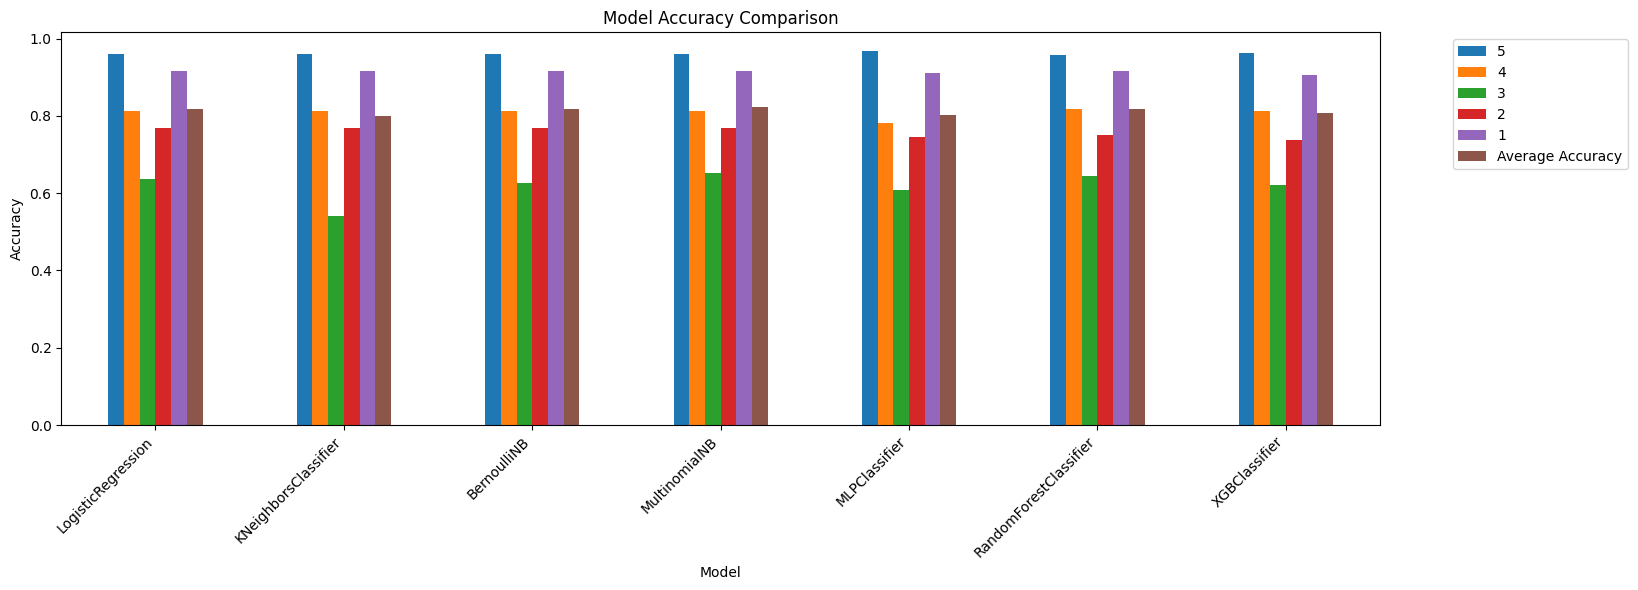

In [27]:
import matplotlib.pyplot as plt

ax = accuracy_df.plot(kind='bar', figsize=(14, 6))
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 4. Treinamento do Modelo
Ajuste os hiperparâmetros usando validação cruzada ou conjuntos de validação.
Escolha uma função de perda adequada para multi-classe, como:
Cross-Entropy Loss (mais comum).
Categorical Hinge Loss.



## 5. Avaliação do Modelo
Use métricas apropriadas para problemas multi-classe:

Matriz de Confusão: Analisa erros entre as classes.
Acurácia: Percentual de previsões corretas.
F1-Score Macro: Média do F1-score entre classes (útil para dados desbalanceados).
AUC-ROC Multiclasse: Mede a qualidade do modelo em problemas de classificação probabilística.

## 6. Explicabilidade

## 6.1 Do Modelo

{'thanks': 0.025533595921766877, 'thank': 0.01868792470878576, 'congratulation': 0.010966728285393815, 'addressing': 0.010292846898344912, 'attachment': 0.008828587038471187, 'file': 0.007582152258623267, 'response': 0.0067612595239820335, 'comment addressed': 0.00621129132634948, 'contribution': 0.0054272676639754765, 'author thank': 0.005379405219509532, 'dear': 0.005093535846008544, 'comment add': 0.004905381250535808, 'comment': 0.004857925935383154, 'congratulate author': 0.004697224230872427, 'dear author': 0.004625130477824147, 'thank author': 0.004484977609195422, 'clarifying': 0.004349109317019202, 'author interesting': 0.004261920434804727, 'attached': 0.004060456364646801, 'make figure': 0.0039680691592380085, 'figure larger': 0.003949467051123335, 'thank contribution': 0.003917257049277832, 'consider carefully': 0.0038626753716950097, 'attached review': 0.0038272707341468278, 'axis figure': 0.0038152742192677663, 'say main': 0.0036458796906674597, 'rivision': 0.003628220673

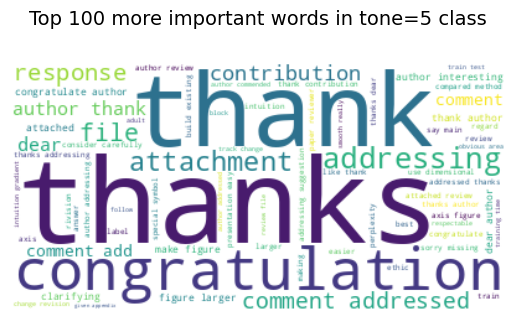

In [30]:
# Derive feature importances
feature_importances_5 = trained_models_['RandomForestClassifier_5'].feature_importances_

# Get the feature names
feature_names_5 = vect_5.get_feature_names_out()

# Create a dictionary mapping feature names to importances
feature_importance_dict_5 = dict(zip(feature_names_5, feature_importances_5))

# Sort the dictionary by importance in descending order and get the top 10
top_features_5 = dict(sorted(feature_importance_dict_5.items(), key=lambda item: item[1], reverse=True)[:100])
print(top_features_5)

# Create and generate a word cloud image
cloud_positives = WordCloud(background_color="white").generate_from_frequencies(top_features_5)

# Display the generated wordcloud image
plt.imshow(cloud_positives, interpolation="bilinear")
plt.title("Top 100 more important words in tone=5 class", y=1.12, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

{'science': 0.01331995765085607, 'rubbish': 0.00784894702649977, 'point': 0.007399045135583126, 'disappointing': 0.007380634576229019, 'author': 0.006337516633004881, 'kidding': 0.006125295651679384, 'jarring': 0.004475046919610536, 'sloppy': 0.004366610462133454, 'stop': 0.004146075684331213, 'research': 0.004107254080203009, 'fence': 0.0038939726704716065, 'omission': 0.0037694313997283, 'chose': 0.0036911064850180487, 'mess': 0.0036278170126650294, 'telling': 0.0035953694026608553, 'piece': 0.003429503563676089, 'bad': 0.0033234233536380588, 'required': 0.0033125702398437897, 'chance': 0.0032044429701313082, 'school': 0.0031885321953237073, 'want': 0.0031749937252185303, 'story telling': 0.0031504320269636105, 'sorry': 0.003115674628087664, 'piece work': 0.0030298219934009624, 'clarify': 0.00301609559350646, 'author tilting': 0.00301386932595199, 'bad bad': 0.0028189084736294904, 'paper': 0.0028108724947828634, 'nice': 0.0027035357018835087, 'annoying': 0.0026937664711306304, 'neede

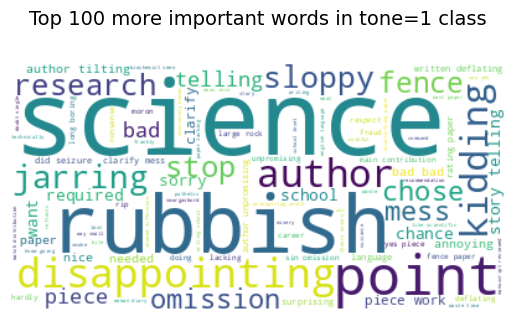

In [31]:
# Derive feature importances
feature_importances_1 = trained_models_['RandomForestClassifier_1'].feature_importances_

# Get the feature names
feature_names_1 = vect_1.get_feature_names_out()

# Create a dictionary mapping feature names to importances
feature_importance_dict_1 = dict(zip(feature_names_1, feature_importances_1))

# Sort the dictionary by importance in descending order and get the top 10
top_features_1 = dict(sorted(feature_importance_dict_1.items(), key=lambda item: item[1], reverse=True)[:100])
print(top_features_1)

# Create and generate a word cloud image
cloud_negatives = WordCloud(background_color="white").generate_from_frequencies(top_features_1)

# Display the generated wordcloud image
plt.imshow(cloud_negatives, interpolation="bilinear")
plt.title("Top 100 more important words in tone=1 class", y=1.12, size=14)  # Choose title, position and size
plt.axis("off")  # Turn off axis labels

# Show the final image
plt.show()

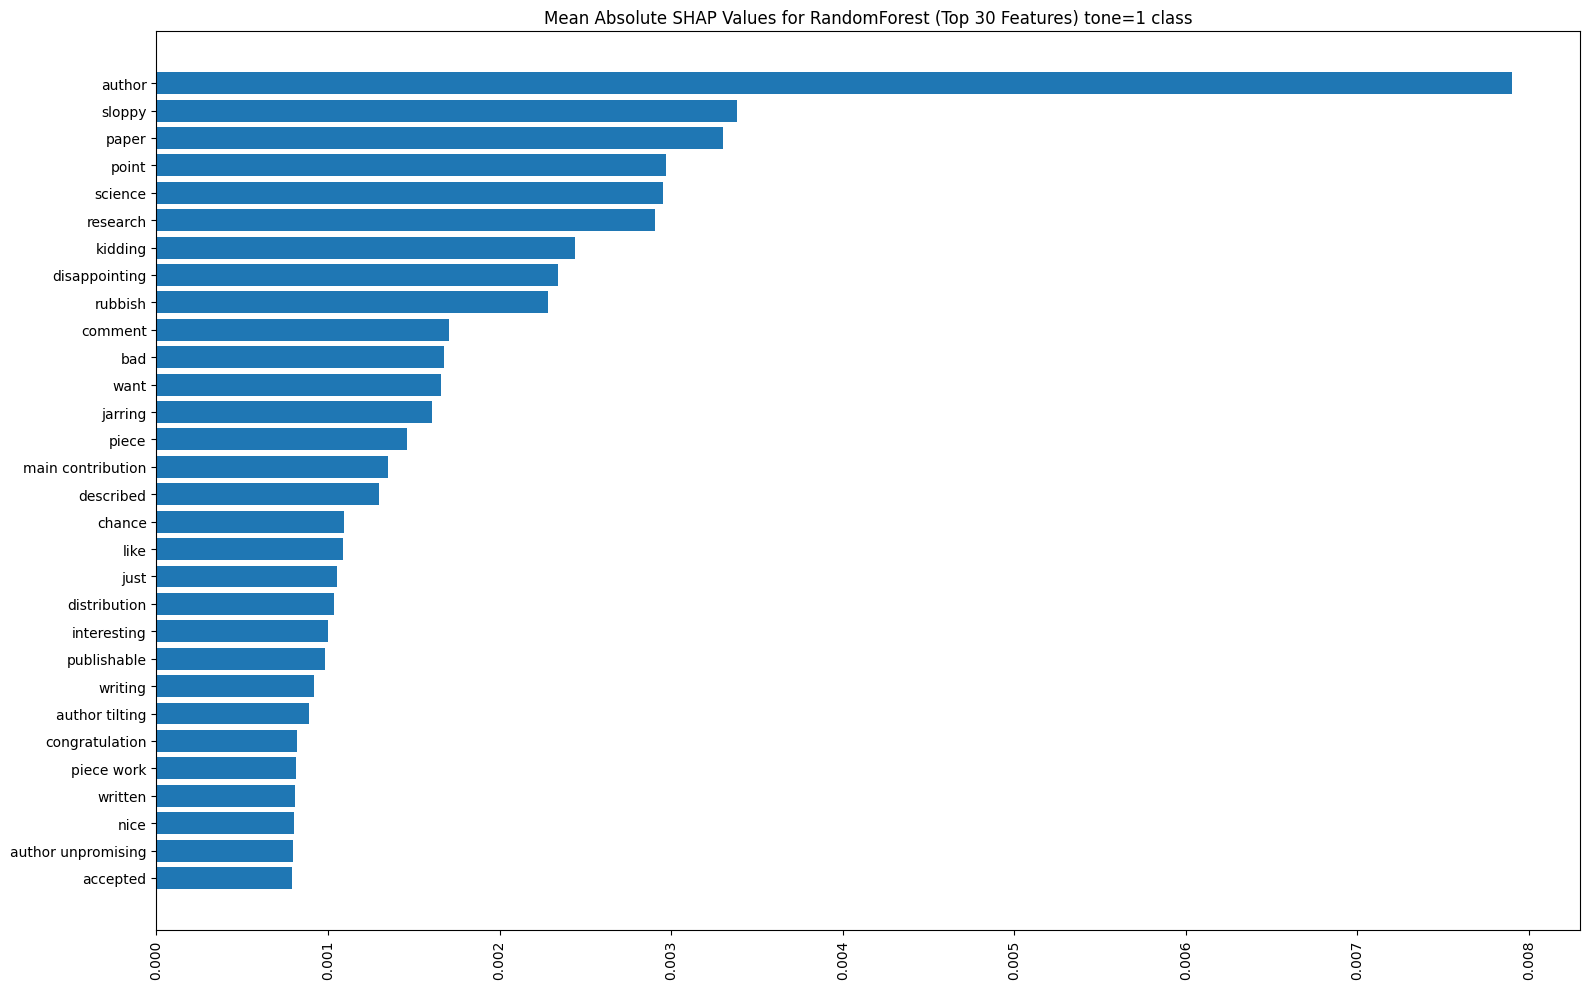

In [32]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(trained_models_['RandomForestClassifier_1'])

# Assuming 'vect_1' is your fitted TfidfVectorizer
# instance_to_explain = X_test_1  # Replace with your instance
# instance_vector = vect_1.transform([instance_to_explain])  # Transform text to TF-IDF vector
instance_vector = X_test_tfidf_1  # Transform text to TF-IDF vector
# Convert the instance_vector to a dense NumPy array with a numeric dtype (e.g., float32)
instance_vector = instance_vector.toarray().astype(np.float32)

# Calculate SHAP values
shap_values = explainer.shap_values(instance_vector, approximate=True, check_additivity=False)

# Calculate SHAP values
# shap_values = explainer.shap_values('this paper sucks!', approximate=True, check_additivity=False)

positive_values = shap_values[:,:,1]

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

top_100_indices = np.argsort(mean_abs_shap)[-30:]  # Indices of top 30 features

# Plot the top 100 features
feature_names = vect_1.get_feature_names_out()  # Get feature names from the vectorizer
plt.figure(figsize=(16, 10))
plt.barh(np.array(feature_names)[top_100_indices], mean_abs_shap[top_100_indices])
# plt.barh(X.columns[top_100_indices], mean_abs_shap[top_100_indices])
plt.title('Mean Absolute SHAP Values for RandomForest (Top 30 Features) tone=1 class')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

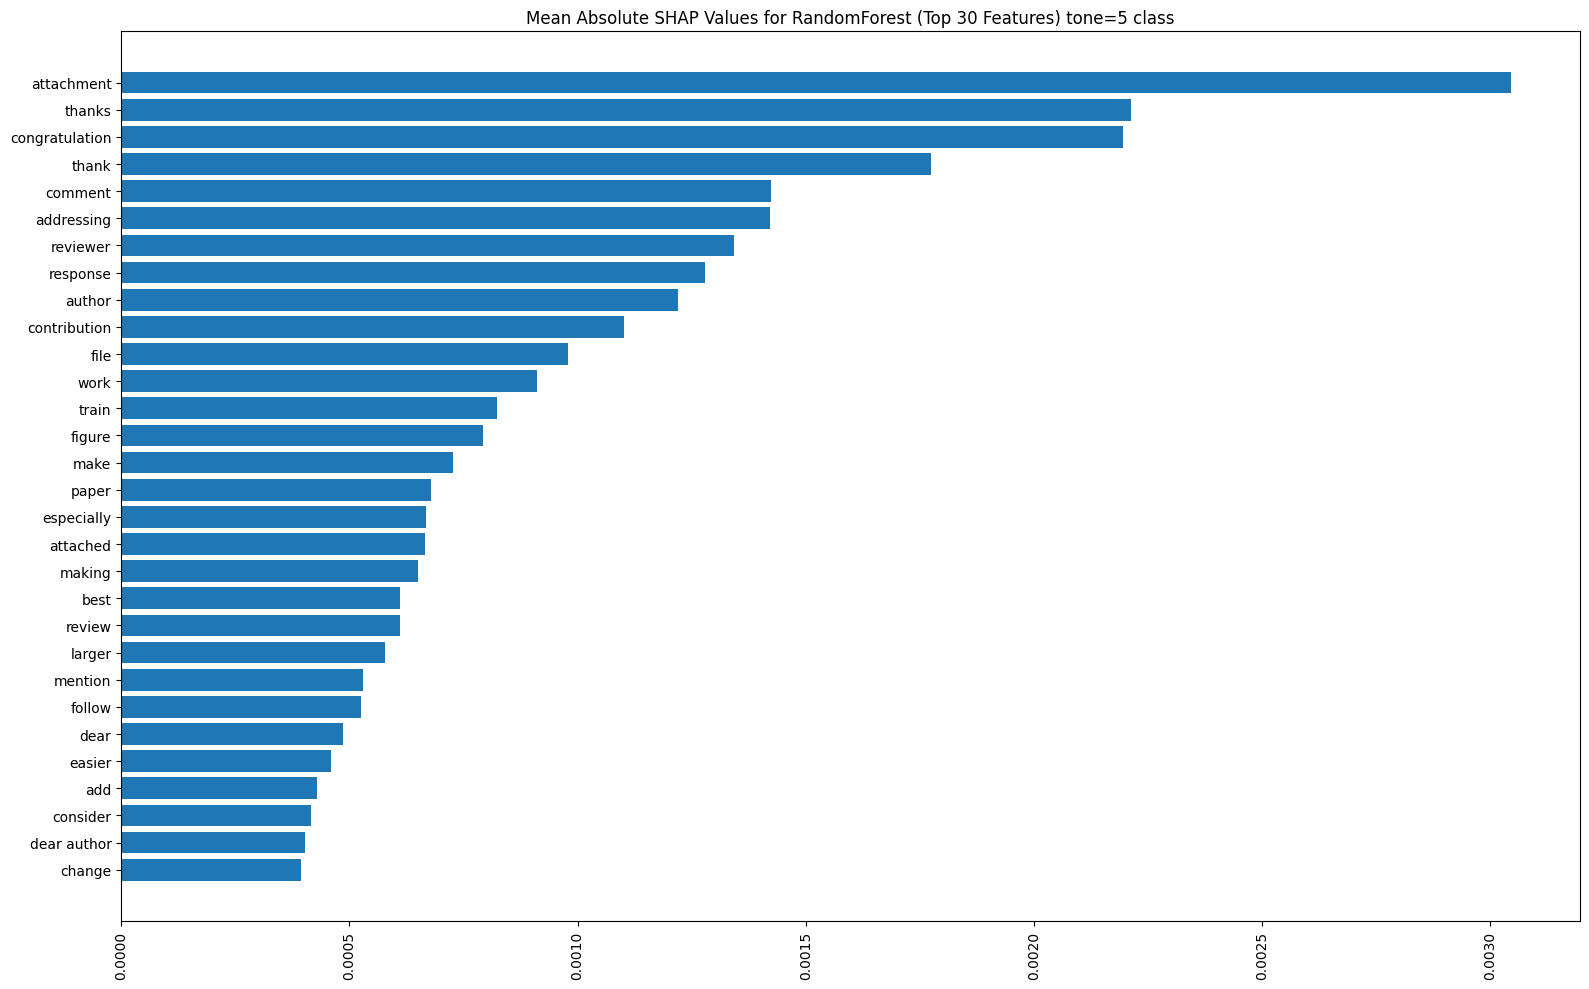

In [33]:
# Create a SHAP Tree Explainer
explainer = shap.TreeExplainer(trained_models_['RandomForestClassifier_5'])

# Assuming 'vect_1' is your fitted TfidfVectorizer
# instance_to_explain = X_test_5.iloc[0]  # Replace with your instance
# instance_vector = vect_5.transform([instance_to_explain])  # Transform text to TF-IDF vector
instance_vector = X_test_tfidf_5
# Convert the instance_vector to a dense NumPy array with a numeric dtype (e.g., float32)
instance_vector = instance_vector.toarray().astype(np.float32)

# Calculate SHAP values
shap_values = explainer.shap_values(instance_vector, approximate=True, check_additivity=False)

# Calculate SHAP values
# shap_values = explainer.shap_values('this paper sucks!', approximate=True, check_additivity=False)

positive_values = shap_values[:,:,1]

# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values[:, :, 1]).mean(axis=0)

top_100_indices = np.argsort(mean_abs_shap)[-30:]  # Indices of top 30 features

# Plot the top 100 features
feature_names = vect_5.get_feature_names_out()  # Get feature names from the vectorizer
plt.figure(figsize=(16, 10))
plt.barh(np.array(feature_names)[top_100_indices], mean_abs_shap[top_100_indices])
# plt.barh(X.columns[top_100_indices], mean_abs_shap[top_100_indices])
plt.title('Mean Absolute SHAP Values for RandomForest (Top 30 Features) tone=5 class')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### 6.2 Explicabilidade local

In [35]:
# Print the first 10 features
# print(vect_1.get_feature_names_out()[:10])

# Print the first 5 vectors of the tfidf training data
# print(X_train_tfidf_1.A[:5])

# print(X_test_1[2174])
print(y_test_1[y_test_1==1])
# print(X_test_tfidf_1.toarray())

X_1 = pd.DataFrame(data=X_test_tfidf_1.toarray(), columns=vect_1.get_feature_names_out())
# X_1.iloc[0,:]

# # Create sparse matrix from the vectorizer
# X = vect.transform(upsampled_df.review_pro2)
# # print(X[20].data)

# # Create a DataFrame
# df_transformed = pd.DataFrame(data=X.toarray(), columns=vect.get_feature_names_out())

# # print(df_transformed.iloc[20])

# for term, tfidf_value in df_transformed.iloc[20].items():
#     if tfidf_value > 0.0:
#         print(f"{term}: {tfidf_value}")

# df_transformed

2174    1
1917    1
191     1
8       1
75      1
1298    1
365     1
2102    1
176     1
254     1
308     1
1368    1
468     1
1689    1
1235    1
882     1
849     1
590     1
366     1
1013    1
29      1
476     1
714     1
56      1
1089    1
154     1
344     1
167     1
1174    1
2011    1
442     1
1059    1
1636    1
618     1
1871    1
447     1
1438    1
413     1
903     1
1218    1
164     1
1977    1
Name: tone_1, dtype: int64


Review: presentation clarity to the best of my understanding the author are some misconception
Probabilidade prevista N/S: [[0.8687563 0.1312437]]
Classe prevista tone=1?: [0]
Classe real tone=1: 1


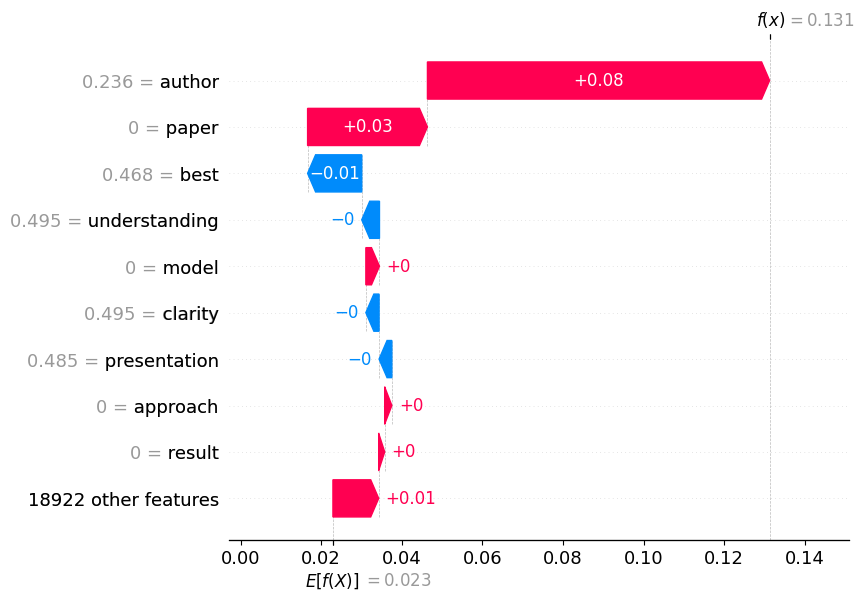

In [36]:
test_idx = 2174

print(f"Review: {X_test_1[test_idx]}")

# Get the index of the instance in X_1 corresponding to X_test_1[2174]
index_in_X_1 = X_test_1.index.get_loc(test_idx)

predicted_proba = trained_models_['RandomForestClassifier_1'].predict_proba(vect_1.transform([X_test_1[test_idx]]))
predicted = trained_models_['RandomForestClassifier_1'].predict(vect_1.transform([X_test_1[test_idx]]))
predicted_all = trained_models_['RandomForestClassifier_1'].predict(vect_1.transform(X_test_1))
print(f"Probabilidade prevista N/S: {predicted_proba}")
print(f"Classe prevista tone=1?: {predicted}")
print(f"Classe real tone=1: {y_1[test_idx]}")

# print(predicted_all[predicted_all==1].index)
# print(np.where(predicted_all == 1)[0])

# Create the SHAP explainer
explainer = shap.KernelExplainer(trained_models_['RandomForestClassifier_1'].predict_proba, shap.kmeans(X_1, 10))

# Compute SHAP values using the correct index
shap_values = explainer.shap_values(X_1.iloc[index_in_X_1,:])

# Plot the SHAP values using a waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[:,1],
                    base_values=explainer.expected_value[1],
                    data=X_1.iloc[index_in_X_1,:],
                    feature_names=X_1.columns))

Review: this information is utterly useless and would not worth any publication at all
Probabilidade prevista N/S: [[0.94562266 0.05437734]]
Classe prevista tone=1?: [0]
Classe real tone=1: 1


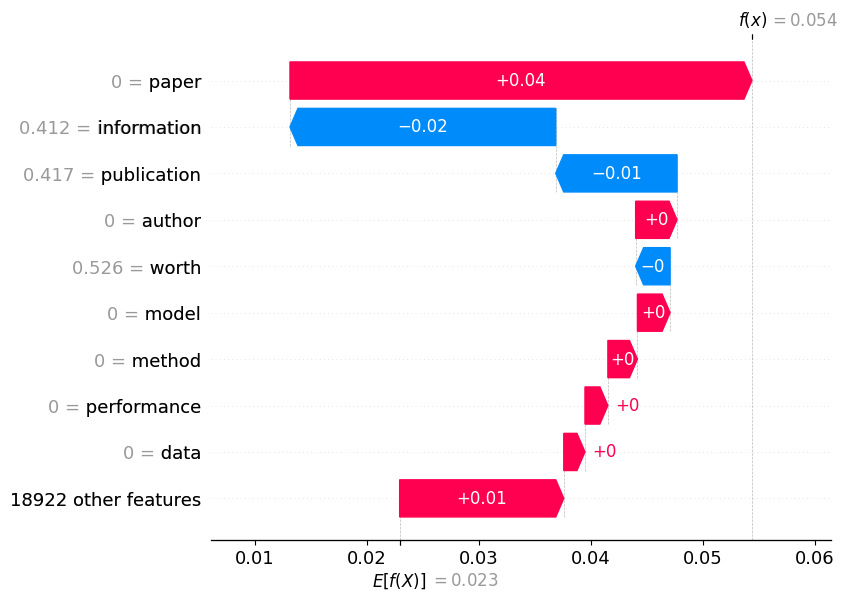

In [37]:
test_idx = 590

print(f"Review: {X_test_1[test_idx]}")

# Get the index of the instance in X_1 corresponding to X_test_1[2174]
index_in_X_1 = X_test_1.index.get_loc(test_idx)

predicted_proba = trained_models_['RandomForestClassifier_1'].predict_proba(vect_1.transform([X_test_1[test_idx]]))
predicted = trained_models_['RandomForestClassifier_1'].predict(vect_1.transform([X_test_1[test_idx]]))
predicted_all = trained_models_['RandomForestClassifier_1'].predict(vect_1.transform(X_test_1))
print(f"Probabilidade prevista N/S: {predicted_proba}")
print(f"Classe prevista tone=1?: {predicted}")
print(f"Classe real tone=1: {y_1[test_idx]}")

# print(predicted_all[predicted_all==1].index)
# print(np.where(predicted_all == 1)[0])

# Create the SHAP explainer
explainer = shap.KernelExplainer(trained_models_['RandomForestClassifier_1'].predict_proba, shap.kmeans(X_1, 10))

# Compute SHAP values using the correct index
shap_values = explainer.shap_values(X_1.iloc[index_in_X_1,:])

# Plot the SHAP values using a waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[:,1],
                    base_values=explainer.expected_value[1],
                    data=X_1.iloc[index_in_X_1,:],
                    feature_names=X_1.columns))

In [57]:
from scipy.sparse import issparse

test_idx = 2174

instance_vector = vect_1.transform([X_test_1[test_idx]])  # Transform the text to TF-IDF vector

# Convert the sparse matrix to a dense NumPy array with a numeric dtype
instance_vector = instance_vector.toarray().astype(np.float32)

# Get the feature names (tokens)
feature_names = vect_1.get_feature_names_out()

# Now pass the instance_vector to the explainer
explainer = shap.Explainer(trained_models_['RandomForestClassifier_1'], feature_names=feature_names, feature_perturbation='interventional') # Disable additivity check

shap_values = explainer(instance_vector, check_additivity=False)

# Access the SHAP values for the desired class (assuming binary classification)
shap_values_class = shap_values[0].values[:, 1]  # Assuming class 1 is the target class

# Convert shap_values_class to a dense NumPy array if it's a sparse matrix
shap_values_class = shap_values_class.toarray().astype(np.float32) if issparse(shap_values_class) else shap_values_class
#print(shap_values_class)
shap.plots.text(shap_values, X_test_1[test_idx]) # Since it's a binary classification

TypeError: slice indices must be integers or None or have an __index__ method

In [53]:
type(shap_values[0].values[:, 1])
type(X_test_1[test_idx])

str

In [45]:
test_idx = 2174

# Get the raw text instance
instance_text = X_test_1[test_idx]

# Transform the text to TF-IDF vector
instance_vector = vect_1.transform([instance_text])

# Get the feature names (tokens)
feature_names = vect_1.get_feature_names_out()

# Create a SHAP explainer for your model
explainer = shap.Explainer(trained_models_['RandomForestClassifier_1'], feature_names=feature_names)

# Calculate SHAP values for the instance
shap_values = explainer(instance_vector)

# Now, plot the SHAP values using the text function, providing the raw text
shap.plots.text(shap_values[0], instance_text)

UFuncTypeError: Cannot cast ufunc 'isnan' input from dtype('O') to dtype('bool') with casting rule 'same_kind'

In [46]:
test_idx = 2174

# Get the raw text instance
instance_text = X_test_1[test_idx]

# Transform the text to TF-IDF vector
instance_vector = vect_1.transform([instance_text])

# **Convert the sparse matrix to a dense NumPy array with a numeric dtype**
instance_vector = instance_vector.toarray().astype(np.float32)

# Get the feature names (tokens)
feature_names = vect_1.get_feature_names_out()

# Create a SHAP explainer for your model
explainer = shap.Explainer(trained_models_['RandomForestClassifier_1'], feature_names=feature_names)

# Calculate SHAP values for the instance
shap_values = explainer(instance_vector)

# Now, plot the SHAP values using the text function, providing the raw text
shap.plots.text(shap_values[0], instance_text)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was -104270019006175249613586626003207337877484025597072078633397112605173324284780995411968.000000, while the model output was 0.868756. If this difference is acceptable you can set check_additivity=False to disable this check.

In [250]:
# Create the SHAP explainer
explainer = shap.KernelExplainer(trained_models_['RandomForestClassifier_5'].predict_proba, shap.kmeans(X_train_tfidf_5, 10))



AttributeError: 'csr_matrix' object has no attribute 'iloc'

In [251]:
# Compute SHAP values for the first instance in X
shap_values = explainer.shap_values(X_test_tfidf_5[0, :])

print(shap_values)

  0%|          | 0/1 [00:00<?, ?it/s]

[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


In [ ]:



def shap_report(X, y):
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    train_X, val_X, train_y, val_y = train_test_split(X, y.values.ravel(), random_state=1)

    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)

        model.fit(train_X, train_y)
        med = train_X.mean().values.reshape((1, train_X.shape[1]))

        # Create object that can calculate shap values
        explainer = shap.KernelExplainer(model.predict_proba, med)
        # Calculate Shap values
        shap_values = explainer.shap_values(val_X.iloc[0:len(train_X), :], nsamples=len(train_X))

        shap.summary_plot(shap_values[1], val_X.iloc[0:len(train_X), :], formatted_dictionary, show=False, color_bar=True,
                          max_display=10,
                          plot_size=(11, 8))

        plt.close()

def roc_curve_report(X, y):
    for a in range(len(models)):
        model = models[a]
        model_name = determine_model_name(model)
        try:
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)
            i = 0
            fig, ax = plt.subplots()
            for i, (train, test) in enumerate(cv.split(X, y)):
                model.fit(X[train], y[train])
                viz = plot_roc_curve(model, X[test], y[test],
                                     name='ROC fold {}'.format(i),
                                     alpha=0.3, lw=1, ax=ax)
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)

            ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                    label='Chance', alpha=.8)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color='b',
                    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                            label=r'$\pm$ 1 std. dev.')

            ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
                   title=model_name)
            ax.legend(loc="lower right")
            plt.savefig(
                "../results/plots/test/roc_%s_%0i_features_%0i_test.pdf" % (
                    model_name, feature_size, len(X)),
                dpi=100, facecolor='w', edgecolor='b', orientation='portrait', transparent=False, bbox_inches=None,
                pad_inches=0.1)
            print("Created %s ROC figure" % model_name)
            plt.close()
        except (AttributeError, OverflowError) as detail:
            print(model_name + " Failed due to ", detail)